# Pima Indians Diabetes Database¶

## Using a Keras based neural network to predict diabetes


This notebook shows how to use a simple Keras based neural network for predicting diabetes. A few things implemented:

- a 3-layer NN 
- model checkpointing / saving
- plotting history

In [4]:
!python3 -m pip install tensorflow==2.0.0

     |████████████████████████████████| 102.7MB 203kB/s eta 0:00:01
     |████████████████████████████████| 450kB 55kB/s eta 0:00:012
     |████████████████████████████████| 1.4MB 596kB/s eta 0:00:01
     |████████████████████████████████| 51kB 13.5MB/s eta 0:00:01
     |████████████████████████████████| 61kB 12.2MB/s eta 0:00:01
     |████████████████████████████████| 2.3MB 634kB/s eta 0:00:011
     |████████████████████████████████| 71kB 11.8MB/s eta 0:00:01
     |████████████████████████████████| 51kB 9.4MB/s  eta 0:00:01
     |████████████████████████████████| 112kB 29.5MB/s eta 0:00:01
     |████████████████████████████████| 3.8MB 31kB/s eta 0:00:0121
     |████████████████████████████████| 92kB 154kB/s eta 0:00:01
     |████████████████████████████████| 81kB 174kB/s eta 0:00:01
     |████████████████████████████████| 133kB 312kB/s eta 0:00:01
     |████████████████████████████████| 153kB 12.8MB/s eta 0:00:01
     |████████████████████████████████| 81kB 12.3MB/s eta 0:00:01
  Crea

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint

seed = 42
np.random.seed(seed)

In [7]:
# load Pima dataset
pdata = pd.read_csv('../data/diabetes.csv')
pdata.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Let's see what the dataset describes

In [8]:
pdata.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Looks like there are some 0-entries in the dataset. This may or may not be important.

In [9]:
# let's remove the 0-entries for these fields

zero_fields = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

def check_zero_entries(data, fields):
    """ List number of 0-entries in each of the given fields"""
    for field in fields:
        print('field %s: num 0-entries: %d' % (field, len(data.loc[ data[field] == 0, field ])))

check_zero_entries(pdata, zero_fields)

field Glucose: num 0-entries: 5
field BloodPressure: num 0-entries: 35
field SkinThickness: num 0-entries: 227
field Insulin: num 0-entries: 374
field BMI: num 0-entries: 11


As one can see, there are several "0" entries, especially for SkinThickness and Insulin. Atleast some of them (e.g. **Insulin**) matter for diabetes predicition. 

Let us split into Train/Test datasets, and then add back the 0-entries by imputing them from the average.
We don't want to impute for the entire dataset at once, since this would affect the performance on the Test set.


In [10]:
# First - split into Train/Test
from sklearn.model_selection import train_test_split

features = list(pdata.columns.values)
features.remove('Outcome')
print(features)
X = pdata[features]
y = pdata['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

print(X_train.shape)
print(X_test.shape)

['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
(576, 8)
(192, 8)


In [11]:
# lets fix the 0-entry for a field in the dataset with its mean value
def impute_zero_field(data, field):
    nonzero_vals = data.loc[data[field] != 0, field]
    avg = np.sum(nonzero_vals) / len(nonzero_vals)
    k = len(data.loc[ data[field] == 0, field])   # num of 0-entries
    data.loc[ data[field] == 0, field ] = avg
    print('Field: %s; fixed %d entries with value: %.3f' % (field, k, avg))

In [12]:
# Fix it for Train dataset
for field in zero_fields:
    impute_zero_field(X_train, field)

Field: Glucose; fixed 4 entries with value: 122.003
Field: BloodPressure; fixed 25 entries with value: 72.846
Field: SkinThickness; fixed 163 entries with value: 29.465
Field: Insulin; fixed 270 entries with value: 158.464
Field: BMI; fixed 8 entries with value: 32.663


/Users/rdua/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [13]:
# double check for the Train dataset
check_zero_entries(X_train, zero_fields)

field Glucose: num 0-entries: 0
field BloodPressure: num 0-entries: 0
field SkinThickness: num 0-entries: 0
field Insulin: num 0-entries: 0
field BMI: num 0-entries: 0


In [14]:
# Fix for Test dataset
for field in zero_fields:
    impute_zero_field(X_test, field)

Field: Glucose; fixed 1 entries with value: 120.738
Field: BloodPressure; fixed 10 entries with value: 71.071
Field: SkinThickness; fixed 64 entries with value: 28.148
Field: Insulin; fixed 104 entries with value: 145.409
Field: BMI; fixed 3 entries with value: 31.841


In [15]:
# double check for the Test dataset
check_zero_entries(X_test, zero_fields)

field Glucose: num 0-entries: 0
field BloodPressure: num 0-entries: 0
field SkinThickness: num 0-entries: 0
field Insulin: num 0-entries: 0
field BMI: num 0-entries: 0


In [16]:
# Ensure that fieldnames aren't included
X_train = X_train.values
y_train = y_train.values
X_test  = X_test.values
y_test  = y_test.values

### Neural Network model

We define a 3-layer NN model in Keras

- First layer: 12 nodes, with RELU activation
- 2nd layer:   8 nodes,  with RELU activation
- 3rd layer:   output,   with sigmoid activation

In [17]:
#from tf.keras.models import Sequential

EPOCHS = 1000  # num of epochs to test for
BATCH_SIZE = 16

## Create our model
model = Sequential()

# 1st layer: input_dim=8, 12 nodes, RELU
#model.add(Dense(12, input_dim=8, init='uniform', activation='relu'))
model.add(Dense(12, input_dim=8, activation='relu'))
# 2nd layer: 8 nodes, RELU
model.add(Dense(8, activation='relu'))
# output layer: dim=1, activation sigmoid
model.add(Dense(1, activation='sigmoid' ))

# Compile the model
model.compile(loss='binary_crossentropy',   # since we are predicting 0/1
             optimizer='adam',
             metrics=['accuracy'])

# checkpoint: store the best model
ckpt_model = 'pima-weights.best.hdf5'
checkpoint = ModelCheckpoint(ckpt_model, 
                            monitor='val_accuracy',
                            verbose=1,
                            save_best_only=True,
                            mode='max')
callbacks_list = [checkpoint]

print('Starting training:')
# train the model, store the results for plotting
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks_list,
                    verbose=0)

Starting training:

Epoch 00001: val_accuracy improved from -inf to 0.32292, saving model to pima-weights.best.hdf5

Epoch 00002: val_accuracy improved from 0.32292 to 0.33854, saving model to pima-weights.best.hdf5

Epoch 00003: val_accuracy improved from 0.33854 to 0.48958, saving model to pima-weights.best.hdf5

Epoch 00004: val_accuracy improved from 0.48958 to 0.53125, saving model to pima-weights.best.hdf5

Epoch 00005: val_accuracy improved from 0.53125 to 0.55208, saving model to pima-weights.best.hdf5

Epoch 00006: val_accuracy improved from 0.55208 to 0.55729, saving model to pima-weights.best.hdf5

Epoch 00007: val_accuracy improved from 0.55729 to 0.64062, saving model to pima-weights.best.hdf5

Epoch 00008: val_accuracy did not improve from 0.64062

Epoch 00009: val_accuracy did not improve from 0.64062

Epoch 00010: val_accuracy did not improve from 0.64062

Epoch 00011: val_accuracy did not improve from 0.64062

Epoch 00012: val_accuracy did not improve from 0.64062

Epo

In [19]:
history.history['loss']

[48.383549213409424,
 22.635261800554062,
 7.574569450484382,
 2.3520228481955,
 1.3617786831325955,
 1.0603748096360102,
 0.9487822420067258,
 0.9028507926397853,
 0.8561584916379716,
 0.8149170478185018,
 0.8078367221686575,
 0.7972893996371163,
 0.7688488902317153,
 0.758462968799803,
 0.7461317628622055,
 0.7169472409619225,
 0.7173429164621565,
 0.70310520960225,
 0.7000767009125816,
 0.6916546887821622,
 0.6810022609101402,
 0.6696474088562859,
 0.6822086489862866,
 0.649726017481751,
 0.7125836710135142,
 0.659113746550348,
 0.6412874336043993,
 0.6530494710637463,
 0.6393468586934937,
 0.6262381590074964,
 0.6391880992386076,
 0.6362803230683008,
 0.6604262085424529,
 0.6218010377552774,
 0.6045426204800606,
 0.5980930435988638,
 0.6140611776047282,
 0.6416235052877002,
 0.613625194463465,
 0.602151500682036,
 0.5885348924332194,
 0.5859512984752655,
 0.5884268805384636,
 0.5838975823587842,
 0.597473767068651,
 0.582150844236215,
 0.563857769800557,
 0.5661943712168269,
 0.566

In [20]:
%matplotlib inline

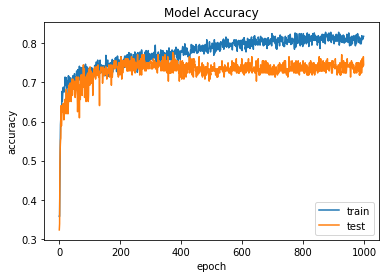

In [21]:
# Model accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

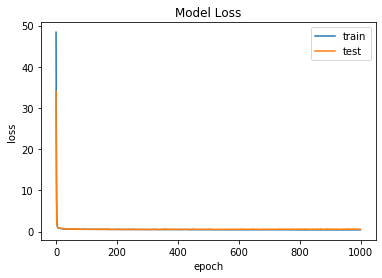

In [23]:
# Model Losss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

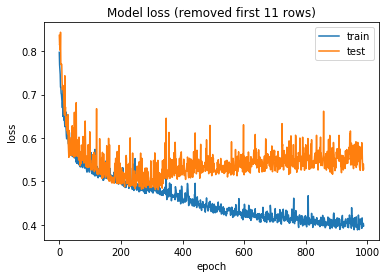

In [38]:
import numpy as np
#plt.plot(np.log(history.history['loss']))
#plt.plot(np.log(history.history['val_loss']))
plt.plot(np.delete(history.history['loss'],[0,1,2,3,4,5,6,7,8,9,10],0))
plt.plot(np.delete(history.history['val_loss'],[0,1,2,3,4,5,6,7,8,9,10],0))
plt.title('Model loss (removed first 11 rows)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

In [29]:
# print final accuracy
scores = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 78.65%


So we see several things:

    - We get accuracy is  about **78%**, which is decent, not great
    - after about 300 epochs, the model does not really improve.
    - After about 500 epochs, the training loss starts to increase, which indicates overfitting

A few things could be done to improve the results:

- Different model architecture (num of nodes, etc)
- Dropout
- Adaptive learning rate